In [45]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [46]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [47]:
NUM_CLASSES = 7

# 学習データ読み込み

In [48]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [49]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [52]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 7)                 77        
                                                                 
Total params: 1147 (4.48 KB)
Trainable params: 1147 (4.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [54]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [55]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
58/68 [========================>.....] - ETA: 0s - loss: 1.7720 - accuracy: 0.2954
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
68/68 [==============================] - 1s 7ms/step - loss: 1.7674 - accuracy: 0.2948 - val_loss: 1.6365 - val_accuracy: 0.3250
Epoch 2/1000
28/68 [===========>..................] - ETA: 0s - loss: 1.6844 - accuracy: 0.3153

C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - ETA: 0s - loss: 1.6448 - accuracy: 0.3208
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
68/68 [==============================] - 0s 6ms/step - loss: 1.6448 - accuracy: 0.3208 - val_loss: 1.4976 - val_accuracy: 0.3544
Epoch 3/1000
57/68 [========================>.....] - ETA: 0s - loss: 1.5432 - accuracy: 0.3509
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
68/68 [==============================] - 0s 6ms/step - loss: 1.5364 - accuracy: 0.3545 - val_loss: 1.3786 - val_accuracy: 0.4699
Epoch 4/1000
60/68 [=========================>....] - ETA: 0s - loss: 1.4664 - accuracy: 0.3876
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
68/68 [==============================] - 0s 6ms/step - loss: 1.4588 - accuracy: 0.3920 - val_loss: 1.2769 - val_accuracy: 0.5477
Epoch 5/1000
55/68 [=======================>......] - ETA: 0s - loss: 1.3965 - accuracy: 0.4237
Epoch 5: savin

In [56]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

23/23 [==============================] - 0s 3ms/step - loss: 0.4956 - accuracy: 0.8800


In [57]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [58]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 83ms/step
[9.1169439e-03 7.4251190e-02 7.8968704e-01 4.5356838e-04 1.1184814e-01
 5.2258428e-03 9.4172033e-03]
2


# 混同行列

91/91 [==============================] - 0s 2ms/step


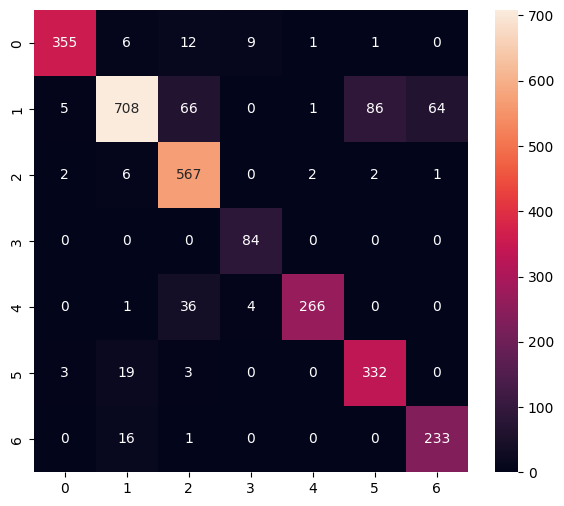

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       384
           1       0.94      0.76      0.84       930
           2       0.83      0.98      0.90       580
           3       0.87      1.00      0.93        84
           4       0.99      0.87      0.92       307
           5       0.79      0.93      0.85       357
           6       0.78      0.93      0.85       250

    accuracy                           0.88      2892
   macro avg       0.88      0.91      0.89      2892
weighted avg       0.89      0.88      0.88      2892



In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [60]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpi27m_4uu\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpi27m_4uu\assets


6704

# 推論テスト

In [62]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [63]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [64]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [65]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [66]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.11694579e-03 7.42511898e-02 7.89687157e-01 4.53567365e-04
 1.11848116e-01 5.22583304e-03 9.41720046e-03]
2
